# Home Energy Management with Spot Market and Affine Peak Power Costs

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import datetime
import pandas as pd
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import calendar
import tqdm
from collections import defaultdict

# Customize plot settings
from latexify import latexify

## Problem data

In [2]:
# Load data
load_data = pd.read_pickle("data/load_data.pickle")
load_min = load_data.min()
load_max = load_data.max()

# Fixed price data
fixed_price_data = pd.read_pickle("data/fixed_price_data.pickle")

# Spot price data
spot_prices_2020_2022 = pd.read_pickle("data/spot_price_data.pickle")
spot_prices_jan2023 = pd.read_pickle("data/spot_price_data_jan2023.pickle")
spot_price_data = pd.concat([spot_prices_2020_2022, spot_prices_jan2023])

# Load forecasting data
load_baseline = pd.read_pickle("data/load_baseline.pickle")
train_residual = pd.read_pickle("data/train_residual.pickle")
AR_params = pd.read_pickle("data/AR_params.pickle")

# Spot price forecasting data
spot_price_baseline = pd.read_pickle("data/spot_price_baseline.pickle")

# Define simulation window: one year with hourly resolution
T = 24 * 365
start_date = pd.Timestamp("2022-01-01 00:00:00")

sim_start_time = load_baseline.index.get_loc(start_date)
sim_end_time = sim_start_time + T
sim_index = load_data.index[sim_start_time:sim_end_time]

# Load and price data for the simulation window
load = load_data.iloc[sim_start_time:sim_end_time].values
fixed_prices = fixed_price_data.iloc[sim_start_time:sim_end_time].values
spot_prices = spot_price_data.iloc[sim_start_time:sim_end_time].values

# Constants for the affine peak power cost
a = 20.35
b = 83

## Functions to plot and print results

In [3]:
def compute_monthly_fixed_cost(fixed_prices, power, sim_index):
    monthly_fixed_cost = []
    for k in range(12):
        month_mask = (sim_index.month == k + 1)
        month_cost = np.sum(fixed_prices[month_mask] * power[month_mask])
        monthly_fixed_cost.append(month_cost)
    return monthly_fixed_cost

def compute_monthly_spot_cost(spot_prices, power, sim_index):
    monthly_spot_cost = []
    for k in range(12):
        month_mask = (sim_index.month == k + 1)
        month_cost = np.sum(spot_prices[month_mask] * power[month_mask])
        monthly_spot_cost.append(month_cost)
    return monthly_spot_cost

def compute_monthly_peak_cost(power, sim_index):
    monthly_peak_cost = []
    for k in range(12):
        month_mask = sim_index.month == k + 1
        month_length = sum(month_mask)
        daily_peak_powers = [power[month_mask][i:i+24].max() for i in range(0, month_length, 24)]
        top_3_daily_peaks = sorted(daily_peak_powers, reverse=True)[:3]
        average_top_3_peaks = sum(top_3_daily_peaks) / 3
        monthly_peak_cost.append(a*average_top_3_peaks + b)
    return monthly_peak_cost

def compute_annual_cost(spot_prices, fixed_prices, power, sim_index):
    monthly_fixed_cost = compute_monthly_fixed_cost(fixed_prices, power, sim_index)
    monthly_spot_cost = compute_monthly_spot_cost(spot_prices, power, sim_index)
    monthly_peak_cost = compute_monthly_peak_cost(power, sim_index)
    
    annual_cost = sum(monthly_fixed_cost) + sum(monthly_spot_cost) + sum(monthly_peak_cost)
    return annual_cost
    
def print_cost_summary(total_cost, spot_cost, fixed_cost, peak_power_cost):
    print(f"Total cost: {total_cost:,.2f} NOK")
    print(f"Fixed cost: {fixed_cost:,.2f} NOK ({100 * fixed_cost / total_cost:.2f}% of total cost)")
    print(f"Spot market cost: {spot_cost:,.2f} NOK ({100 * spot_cost / total_cost:.2f}% of total cost)")
    print(f"Peak power cost: {peak_power_cost:,.2f} NOK ({100 * peak_power_cost / total_cost:.2f}% of total cost)")
    
# Compute z: monthly average of the largest 3 daily peak powers
def compute_z(power, sim_index):
    z_values = []
    for k in range(12):
        month_mask = (sim_index.month == k + 1)
        month_length = sum(month_mask)
        daily_peak_powers = [power[month_mask][i:i+24].max() for i in range(0, month_length, 24)]
        avg_top_3_peaks = sum(sorted(daily_peak_powers, reverse=True)[:3]) / 3
        z_values.extend([avg_top_3_peaks] * month_length)
    return pd.Series(z_values, index=sim_index)

def plot_monthly_costs(monthly_spot_cost, monthly_fixed_cost, monthly_peak_cost, filename=None, save=False):
    months = range(1, 13)
    latexify(fig_width=6)
    fig, ax = plt.subplots()
    plt.bar(months, monthly_fixed_cost, label='Fixed cost')
    plt.bar(months, monthly_peak_cost, bottom=monthly_fixed_cost, label='Peak power cost')
    plt.bar(months, monthly_spot_cost, bottom=[i+j for i,j in zip(monthly_fixed_cost, monthly_peak_cost)], label='Spot market cost')
    plt.xticks(months, [calendar.month_abbr[m] for m in months])
    plt.ylabel('Cost (NOK)')
    plt.legend()

    if save:
        if filename is None:
            raise ValueError("A filename must be provided when 'save' is set to True.")
        plt.savefig(filename)

def customize_monthly_x_axis(ax, interval):
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=interval))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    
def plot_grid_power(sim_index, power, filename=None, save=False):
    z = compute_z(power, sim_index)

    latexify(fig_width=6)
    fig, ax = plt.subplots()
    ax.plot(sim_index, power, color="tab:blue", alpha=0.8, label="Power extracted from the grid")
    ax.plot(sim_index, z, color="k", label="Monthly avg. of 3 daily peak powers")
    plt.ylabel("Power (kW)")
    customize_monthly_x_axis(ax, interval=1)
    # legend = plt.legend()

    if save:
        if filename is None:
            raise ValueError("A filename must be provided when 'save' is set to True.")
        plt.savefig(filename)
    
def print_and_plot_costs(spot_prices, fixed_prices, power, sim_index, filename=None, save=False):
    monthly_fixed_cost = compute_monthly_fixed_cost(fixed_prices, power, sim_index)
    monthly_spot_cost = compute_monthly_spot_cost(spot_prices, power, sim_index)
    monthly_peak_cost = compute_monthly_peak_cost(power, sim_index)

    annual_cost = sum(monthly_fixed_cost) + sum(monthly_spot_cost) + sum(monthly_peak_cost)
    annual_spot_cost = sum(monthly_spot_cost)
    annual_fixed_cost = sum(monthly_fixed_cost)
    annual_peak_cost = sum(monthly_peak_cost)

    print_cost_summary(annual_cost, annual_spot_cost, annual_fixed_cost, annual_peak_cost)
    plot_monthly_costs(monthly_spot_cost, monthly_fixed_cost, monthly_peak_cost, filename, save=save)
    
def plot_state_of_charge(sim_index, state_of_charge, filename=None, save=False):
    latexify(fig_width=6)
    fig, ax = plt.subplots()
    ax.plot(sim_index, state_of_charge, color="tab:blue", alpha=0.8)
    plt.ylabel("State of charge (kWh)")
    customize_monthly_x_axis(ax, interval=1)

    if save:
        if filename is None:
            raise ValueError("A filename must be provided when 'save' is set to True.")
        plt.savefig(filename)

## Baseline analysis: no storage

Total cost: 24,687.07 NOK
Fixed cost: 8,676.61 NOK (35.15% of total cost)
Spot market cost: 13,336.45 NOK (54.02% of total cost)
Peak power cost: 2,674.00 NOK (10.83% of total cost)


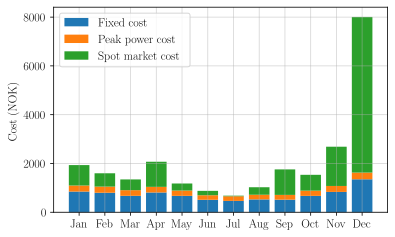

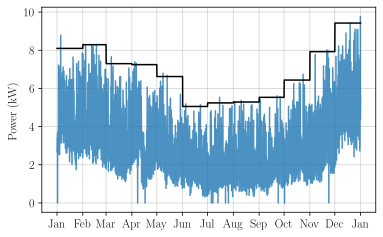

In [4]:
print_and_plot_costs(spot_prices, fixed_prices, load, sim_index, filename="figures/cost_no_storage_affine.pdf", save=True)
plot_grid_power(sim_index, load, filename="figures/grid_power_no_storage.pdf", save=True)
cost_no_storage = compute_annual_cost(spot_prices, fixed_prices, load, sim_index)

## Prescient analysis (perfect knowledge of the future)

Total cost: 21,736.22 NOK
Fixed cost: 8,160.59 NOK (37.54% of total cost)
Spot market cost: 11,396.32 NOK (52.43% of total cost)
Peak power cost: 2,179.31 NOK (10.03% of total cost)


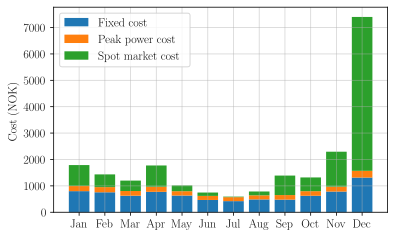

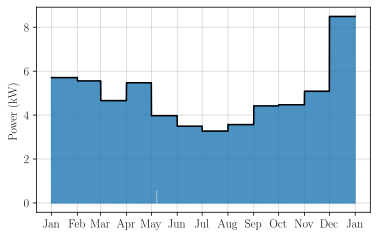

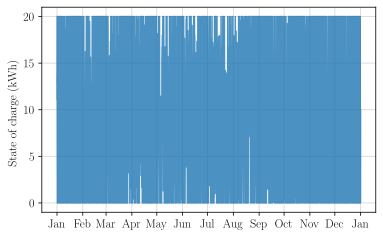

In [5]:
# Constants
storing_efficiency = 1-0.0001
P = 20

# Parameters
Q = cp.Parameter(nonneg=True, value=0)
C = cp.Parameter(nonneg=True, value=Q.value / 2)
D = cp.Parameter(nonneg=True, value=Q.value / 2)
q_init = cp.Parameter(nonneg=True, value=Q.value / 2)
q_final = cp.Parameter(nonneg=True, value=Q.value / 2)

# Variables
p = cp.Variable(T)  # Grid power
u = cp.Variable(T)  # Battery power
q = cp.Variable(T+1)  # State of charge

# Constraints
cons = [p >= 0, p <= P,
        load == p + u,
        q[1:] == storing_efficiency * q[:-1] - u,
        q[0] == q_init, q[-1] == q_final,
        q >= 0, q <= Q,
        -C <= u, u <= D]

fixed_cost = cp.sum(cp.multiply(fixed_prices, p))
spot_cost = cp.sum(cp.multiply(spot_prices, p))

# Compute peak cost
K = 12
month_masks = [(sim_index.month == k + 1) for k in range(K)]
peak_cost = 0
for k in range(K):
    month_mask = month_masks[k]
    p_month = p[month_mask]
    month_length = sum(month_mask)
    p_daily_max = [cp.max(p_month[i:i+24]) for i in range(0, month_length, 24)]
    z = 1/3 * cp.sum_largest(cp.hstack(p_daily_max), 3)
    peak_cost += a*z + b

# Total cost
cost = fixed_cost + spot_cost + peak_cost

# Create optimization problem
problem = cp.Problem(cp.Minimize(cost), cons)

# Set parameter values
Q.value = 20
C.value = Q.value / 2
D.value = Q.value / 2
q_init.value = Q.value / 2
q_final.value = Q.value / 2

# Solve the problem
problem.solve()

# Report results
print_and_plot_costs(spot_prices, fixed_prices, p.value, sim_index, "figures/cost_prescient_affine.pdf", save=True)
plot_grid_power(sim_index, p.value, "figures/grid_power_prescient_affine.pdf", save=True)
plot_state_of_charge(sim_index, q.value[1:], "figures/soc_prescient_affine.pdf", save=True)
cost_prescient = compute_annual_cost(spot_prices, fixed_prices, p.value, sim_index)

In [ ]:
p_prescient = p.value

latexify(fig_width=6)
fig, ax = plt.subplots()
ax.plot(sim_index, p.value, color="tab:orange", alpha=0.8, label="Prescient, 25 kWh storage")
ax.plot(sim_index, load, color="tab:blue", alpha=0.6, label="No storage")
plt.ylabel("Power (kW)")
customize_monthly_x_axis(ax, interval=1)
plt.legend()

## Cost versus storage capacity

In [ ]:
storage_capacities = np.linspace(0, 100)

fixed_cost_values = np.zeros(len(storage_capacities))
spot_cost_values = np.zeros(len(storage_capacities))
peak_cost_values = np.zeros(len(storage_capacities))

for i, capacity in tqdm.tqdm(enumerate(storage_capacities), total=len(storage_capacities), desc="Performing sensitivity analysis"):
    Q.value = capacity
    C.value = Q.value / 2
    D.value = Q.value / 2
    q_init.value = Q.value / 2
    q_final.value = Q.value / 2
    
    problem.solve()

    assert problem.status == cp.OPTIMAL, f"Solver failed to find an optimal solution. Problem status: {problem.status}"

    fixed_cost_values[i] = fixed_cost.value
    spot_cost_values[i] = spot_cost.value
    peak_cost_values[i] = peak_cost.value


total_cost_values = fixed_cost_values + spot_cost_values + peak_cost_values
total_savings_percetage = (total_cost_values[0] - total_cost_values)/total_cost_values[0] * 100

latexify(fig_width=6)
plt.figure()
plt.plot(storage_capacities, total_savings_percetage, color="black", linestyle="solid")
plt.xlabel("Storage capacity (kWh)")
plt.ylabel("Annual savings (\%)")
plt.savefig("figures/savings_vs_storage_capacity_affine.pdf")

## Model predictive control policy

In [ ]:
def run_mpc(loads, da_prices, tou_prices, datetimes, q_init, q_final, N_largest_daily_powers, max_daily_power, H, N=3, a=20.35, b=83):
    p = cp.Variable(H) 
    u = cp.Variable(H) 
    q = cp.Variable(H+1)

    cons = [p >= 0, p <= P,
            loads == p + u,
            q[1:] == storing_efficiency * q[:-1] - u,
            q[0] == q_init, q[-1] == q_final, 
            q >= 0, q <= Q,
            -C <= u, u <= D]
    
    energy_cost = cp.sum(cp.multiply(tou_prices + da_prices, p))
    
    peak_power_cost = 0
    unique_months = pd.unique(datetimes.month)

    for month in unique_months:
        month_mask = datetimes.month == month
        unique_days_in_month = pd.unique(datetimes[month_mask].date)

        daily_max_powers = []

        for day in unique_days_in_month:
            day_mask = (datetimes.date == day) & month_mask
            if max_daily_power != 0 and day == datetimes[0].day:
                daily_max_powers.append(cp.maximum(cp.max(p[day_mask]), max_daily_power))
            else:
                daily_max_powers.append(cp.max(p[day_mask]))
        
        if month == datetimes[0].month:
            # prev_average_N_largest = cp.sum_largest(cp.hstack([max_daily_power] + N_largest_daily_powers), min(N, len(unique_days_in_month))) / min(N, len(unique_days_in_month))
            # prev_peak_power_cost = a * prev_average_N_largest + b
            average_N_largest = cp.sum_largest(cp.hstack(daily_max_powers + N_largest_daily_powers), min(N, len(unique_days_in_month))) / min(N, len(unique_days_in_month))
            # curr_peak_power_cost = a * curr_average_N_largest + b
            # peak_power_cost += cp.pos(curr_peak_power_cost - prev_peak_power_cost)
        else:
            average_N_largest = cp.sum_largest(cp.hstack(daily_max_powers), min(N, len(unique_days_in_month))) / min(N, len(unique_days_in_month))
        
        peak_power_cost += a * average_N_largest + b
    
    cost = energy_cost + peak_power_cost
    problem = cp.Problem(cp.Minimize(cost), cons)
    problem.solve()

    u0, p0 = u.value[0], p.value[0]
    return u0, p0


def predict_load(load, baseline, AR_params, t, M, L):
    past = load[t-M:t]
    past_baseline = baseline[t-M:t]
    fut_baseline = baseline[t:t+L]
    pred = list(reversed(past-past_baseline)) @ AR_params
    
    pred = pd.Series(pred, index=fut_baseline.index)
    pred += fut_baseline
    pred = np.maximum(load_min, pred)
    pred = np.minimum(load_max, pred)
    return pred

def make_load_forecast(t, H, M, L):
    curr_load = np.array([load_data[sim_start_time + t]])
    baseline_AR_forecast = predict_load(load_data, load_baseline, AR_params, sim_start_time+t+1, M, L)[:H-1]

    if H > L:
        baseline_forecast = load_baseline[sim_start_time+t+1+L:sim_start_time+t+H]
    else:
        baseline_forecast = np.array([])

    load_forecast = np.concatenate((curr_load, baseline_AR_forecast, baseline_forecast))
    return load_forecast

def make_spot_price_forecast(t, H):
    # Determine hours with known prices
    if sim_index[t].hour < 13:
        hours_with_known_prices = 24 - sim_index[t].hour
    else:
        hours_with_known_prices = (24-sim_index[t].hour) + 24
    # Create forecast
    if hours_with_known_prices > H:
        spot_price_forecast = spot_price_data[sim_start_time+t:sim_start_time+t+H].values
    else:
        spot_price_forecast = np.concatenate((spot_price_data[sim_start_time+t:sim_start_time+t+hours_with_known_prices].values, spot_price_baseline[sim_start_time+t+hours_with_known_prices:sim_start_time+t+H]))
    return spot_price_forecast

def update_N_largest_daily_powers(N_largest_daily_powers, max_daily_power, N):
    if len(N_largest_daily_powers) < N:
        N_largest_daily_powers.append(max_daily_power)
    else:
        min_value = min(N_largest_daily_powers)
        if max_daily_power > min_value:
            N_largest_daily_powers[N_largest_daily_powers.index(min_value)] = max_daily_power
    return N_largest_daily_powers

In [ ]:
# Constants
Q = 20
C, D, q_init, q_final = Q/2, Q/2, Q/2, Q/2
H = 24*30
M, L = 24, 24
N = 3

T = 24*365
sim_index = load_data.index[sim_start_time:sim_start_time+T]

p_values = np.zeros(T)
q_values = np.zeros(T+1)

N_largest_daily_powers = []
max_daily_power = 0

q_values[0] = q_init
prev_datetime = sim_index[0]

# MPC loop
for t in tqdm.trange(T):
    
    # Current datetime and state of charge
    datetime = sim_index[t]
    q = q_values[t]
    
    # Reset N_largest_daily_powers if new month
    if prev_datetime.month != datetime.month:
        N_largest_daily_powers = []
    
    # Update N_largest_daily_powers and max_daily_power
    if prev_datetime.day != datetime.day:
        N_largest_daily_powers = update_N_largest_daily_powers(N_largest_daily_powers, max_daily_power, N)
        max_daily_power = 0
    
    # Forecast loads, time-of-use prices and day-ahead prices over a horizon H
    load_forecast = make_load_forecast(t, H, M, L)
    da_price_forecast = make_spot_price_forecast(t, H)
    tou_price_forecast = fixed_price_data[sim_start_time+t:sim_start_time+t+H].values
    
    # Get datetimes for the horizon
    datetimes = load_baseline.index[sim_start_time+t:sim_start_time+t+H]
    
    # Run MPC to make a plan of actions over a horizon and get the first action of the plan
    u, p = run_mpc(load_forecast, da_price_forecast, tou_price_forecast, datetimes, q, q_final, N_largest_daily_powers, max_daily_power, H)

    # Execute first action and update states in the simulation
    p_values[t] = p
    q_values[t+1] = storing_efficiency * q - u
    prev_datetime = datetime
    max_daily_power = np.maximum(max_daily_power, p)
        

In [ ]:
print_and_plot_costs(spot_prices, fixed_prices, p_values, sim_index, filename="figures/cost_mpc_affine.pdf", save=True)
plot_grid_power(sim_index, p_values, filename="figures/grid_power_mpc_affine.pdf", save=True)
plot_state_of_charge(sim_index, q_values[1:], filename="figures/soc_mpc_affine.pdf", save=True)
cost_mpc = compute_annual_cost(spot_prices, fixed_prices, p_values, sim_index)


In [ ]:
latexify(fig_width=6)
fig, ax = plt.subplots()
ax.plot(sim_index, p_values, color="tab:green", alpha=0.8, label="MPC")
ax.plot(sim_index, p_prescient, color="tab:orange", alpha=0.7, label="Prescient")
ax.plot(sim_index, load, color="tab:blue", alpha=0.8, label="No storage")
plt.ylabel("Power (kW)")
customize_monthly_x_axis(ax, interval=1)
plt.legend(ncol=3)

## Cost comparison

In [ ]:
print(f"Cost without storage: {cost_no_storage:,.2f} NOK")
print(f"Prescient cost with 20 kWh of storage capacity: {cost_prescient:,.2f} NOK")
print(f"MPC cost with 20 kWh of storage capacity: {cost_mpc:,.2f} NOK")

relative_gap = (abs(cost_mpc - cost_prescient) / abs(cost_prescient)) * 100
print(f"Relative gap between MPC cost and prescient cost: {relative_gap:.2f}%")
print(f"Annual savings with MPC policy and 20 kWh of storage capacity: {cost_no_storage-cost_mpc:.2f} NOK ({100 * (cost_no_storage-cost_mpc) / cost_no_storage:.2f}%)")